## Librerias 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
from lib.LCWavelet import *
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

## Arquitectura del modelo

In [2]:
class ShallueModel(nn.Module):
    def __init__(self, global_size=2001, local_size=201, num_classes=2):
        super(ShallueModel, self).__init__()
        self.global_size = global_size
        self.local_size = local_size
        self.num_classes = num_classes
        if num_classes == 1:
            print("Binary classification, sigmoid activation will be used.")
        elif num_classes > 1:
            print("Multi-class classification, softmax activation will be used.")
            
        
        self.conv_global_odd = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(64, 128, 5),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(128, 256, 5),
            nn.ReLU(),
            nn.Conv1d(256, 256, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
        )
        
        self.conv_global_even = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(32, 64, 5),
            nn.ReLU(),
            nn.Conv1d(64, 64, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(64, 128, 5),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
            nn.Conv1d(128, 256, 5),
            nn.ReLU(),
            nn.Conv1d(256, 256, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride=2),
        )
        
        self.conv_local_odd = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
        )
        
        self.conv_local_even = nn.Sequential(
            nn.Conv1d(1, 16, 5),
            nn.ReLU(),
            nn.Conv1d(16, 16, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
            nn.Conv1d(16, 32, 5),
            nn.ReLU(),
            nn.Conv1d(32, 32, 5),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=7, stride=2),
        )
        
        # Calcular automáticamente el número de features resultantes de la concatenación
        with torch.no_grad():
            dummy_global = torch.zeros(1, 1, self.global_size)
            dummy_local = torch.zeros(1, 1, self.local_size)
            out_global_odd  = self.conv_global_odd(dummy_global)
            out_global_even = self.conv_global_even(dummy_global)
            out_local_odd   = self.conv_local_odd(dummy_local)
            out_local_even  = self.conv_local_even(dummy_local)
            
            # Flatten cada salida y sumar sus dimensiones
            num_features = out_global_odd.view(1, -1).size(1) + \
                           out_global_even.view(1, -1).size(1) + \
                           out_local_odd.view(1, -1).size(1) + \
                           out_local_even.view(1, -1).size(1)
            
        print("Número de features concatenados:", num_features)
        
        self.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, inputs):
        global_odd = self.conv_global_odd(inputs[0])
        global_even = self.conv_global_even(inputs[1])
        local_odd = self.conv_local_odd(inputs[2])
        local_even = self.conv_local_even(inputs[3])
        
        global_odd = global_odd.view(global_odd.size(0), -1)
        global_even = global_even.view(global_even.size(0), -1)
        local_odd = local_odd.view(local_odd.size(0), -1)
        local_even = local_even.view(local_even.size(0), -1)
        
        # Concatenación de todas las ramas
        x = torch.cat((global_odd, global_even, local_odd, local_even), dim=1)
        x = self.fc(x)
        if self.num_classes > 1:
            return F.softmax(x, dim=1)
        else:
            return torch.sigmoid(x)
    

## Cargado de datos

In [3]:
def load_data(path, file_name):
    lc = LightCurveWaveletGlobalLocalCollection.from_pickle(path + file_name)
    try:
        getattr(lc, 'levels')
    except AttributeError:
        lc.levels = [1, 2, 3, 4]
    return lc
        
path='all_data/'
files = os.listdir(path)
kepler_files = [f for f in files if f.endswith('.pickle')]
light_curves = []

for file in tqdm(kepler_files, desc='Loading data'):
    light_curves.append(load_data(path, file))

Loading data: 100%|██████████| 9346/9346 [00:44<00:00, 209.92it/s]


### Separar entre los confirmados y candidatos

In [4]:
candidates = [lc for lc in light_curves if lc.headers['class'] == 'CANDIDATE']
print("Número de candidatos:", len(candidates))

confirmed = [lc for lc in light_curves if lc.headers['class'] == 'CONFIRMED' or lc.headers['class'] == 'FALSE POSITIVE']
print("Número de confirmados:", len(confirmed))

classes = [lc.headers['class'] for lc in confirmed]
classes = set(classes)
classes = {v: k for k, v in enumerate(classes)}
print("Clases:", classes)

Número de candidatos: 2046
Número de confirmados: 7300
Clases: {'FALSE POSITIVE': 0, 'CONFIRMED': 1}


In [5]:
global_odd = []
global_even = []
local_odd = []
local_even = []
labels = []

for lc in tqdm(confirmed, desc='Processing light curves'):
    global_odd.append(lc.pliegue_impar_global._light_curve.flux.value)
    global_even.append(lc.pliegue_par_global._light_curve.flux.value)
    local_odd.append(lc.pliegue_impar_local._light_curve.flux.value)
    local_even.append(lc.pliegue_par_local._light_curve.flux.value)
    # Convertir la clase a un número entero
    labels.append(classes[lc.headers['class']])
    
print("Número de datos:", len(global_odd))
print('Elementos de cada clase:', {k: labels.count(k) for k in set(labels)})


Processing light curves: 100%|██████████| 7300/7300 [00:00<00:00, 97072.21it/s]

Número de datos: 7300
Elementos de cada clase: {0: 4637, 1: 2663}


### Separar las muestras en train y test

In [6]:
items = []

for i in tqdm(range(len(global_odd)), desc='Creating items'):
    item = {
        'global_odd': global_odd[i],
        'global_even': global_even[i],
        'local_odd': local_odd[i],
        'local_even': local_even[i],
        'label': labels[i]
    }
    items.append(item)

train, test = train_test_split(items, test_size=0.3, random_state=42)
train_global_odd = torch.tensor([item['global_odd'] for item in train])
train_global_even = torch.tensor([item['global_even'] for item in train])
train_local_odd = torch.tensor([item['local_odd'] for item in train])
train_local_even = torch.tensor([item['local_even'] for item in train])
train_labels = torch.tensor([item['label'] for item in train])

test_global_odd = torch.tensor([item['global_odd'] for item in test])
test_global_even = torch.tensor([item['global_even'] for item in test])
test_local_odd = torch.tensor([item['local_odd'] for item in test])
test_local_even = torch.tensor([item['local_even'] for item in test])
test_labels = torch.tensor([item['label'] for item in test])

train_dataset = torch.utils.data.TensorDataset(train_global_odd, train_global_even, train_local_odd, train_local_even, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_global_odd, test_global_even, test_local_odd, test_local_even, test_labels)

print("Tamaño del conjunto de entrenamiento:", len(train_dataset))
print("Tamaño del conjunto de prueba:", len(test_dataset))

Creating items: 100%|██████████| 7300/7300 [00:00<00:00, 1396825.69it/s]
e:\Diego\Astrofisica\TFM\ExoPlanet-Detection\.venv\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  


Tamaño del conjunto de entrenamiento: 5110
Tamaño del conjunto de prueba: 2190


## Entrenar el modelo

#### Definir device en caso de usar GPU o CPU

In [7]:
try:
    import torch_directml
    if torch_directml.is_available():
        device = torch_directml.device()
    else:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dispositivo:", device)
except ImportError:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Dispositivo:", device)

Dispositivo: privateuseone:0


In [ ]:
batch_size = 64
num_epochs = 10
learning_rate = 0.0001
n_classes = 2 # si pones 1 usa sigmoid, si pones >1 usa softmax
if n_classes > 1:
    loss_fn = nn.CrossEntropyLoss() # para clasificación multiclase
else:
    loss_fn = nn.BCELoss() # para clasificación binaria con sigmoid
    
model = ShallueModel(global_size=2001, local_size=201, num_classes=n_classes).to(device)
if input("¿Quieres inicializar el modelo? (s/n): ").lower() == 's':  
    try: 
        model.load_state_dict(torch.load('models/Shallue_model.pth'))
        model.eval()
    except:
        print("No se pudo cargar el modelo. Se inicializa uno nuevo.")


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Multi-class classification, softmax activation will be used.
Número de features concatenados: 28672


In [9]:
def train_fn(model, train_loader, optimizer, loss_fn):
    model.train()
    train_size = len(train_loader.dataset)
    n_batches = len(train_loader)
    total_loss = 0.0
    correct = 0
    for batch, data in enumerate(tqdm(train_loader, desc='Training')):
        global_odd, global_even, local_odd, local_even, labels = data
        # check if any tensor is empty
        if global_odd.numel() == 0 or global_even.numel() == 0 or local_odd.numel() == 0 or local_even.numel() == 0:
            continue
        # check if any tensor has nan
        if torch.isnan(global_odd).any() or torch.isnan(global_even).any() or torch.isnan(local_odd).any() or torch.isnan(local_even).any():
            continue
        # Move data to device
        global_odd = global_odd.to(device).unsqueeze(1).float()
        global_even = global_even.to(device).unsqueeze(1).float()
        local_odd = local_odd.to(device).unsqueeze(1).float()
        local_even = local_even.to(device).unsqueeze(1).float()
        labels = labels.to(device)
        
        optimizer.zero_grad()
        # Forward propagation
        outputs = model((global_odd, global_even, local_odd, local_even))
        
        if type(loss_fn) == nn.BCELoss:
            # elimnar la dimensión extra de outputs
            outputs = outputs.squeeze(1)
            labels = labels.float()
        # Compute loss and backpropagation
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if type(loss_fn) == nn.BCELoss:
            predicted = (outputs > 0.5).float()
        else:
            _, predicted = torch.max(outputs.data, 1)
            
        correct += (predicted == labels).sum().item()

    accuracy = correct / train_size
    train_loss = total_loss / n_batches
        
    return train_loss, accuracy


def val_fn(model, test_loader, loss_fn):
    model.eval()
    test_size = len(test_loader.dataset)
    n_batches = len(test_loader)
    total_loss = 0.0
    correct = 0
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for batch, data in enumerate(tqdm(test_loader, desc='Validation')):
            global_odd, global_even, local_odd, local_even, labels = data
            # check if any tensor is empty
            if global_odd.numel() == 0 or global_even.numel() == 0 or local_odd.numel() == 0 or local_even.numel() == 0:
                continue
            # check if any tensor has nan
            if torch.isnan(global_odd).any() or torch.isnan(global_even).any() or torch.isnan(local_odd).any() or torch.isnan(local_even).any():
                continue
            
            # Move data to device
            global_odd = global_odd.to(device).unsqueeze(1).float()
            global_even = global_even.to(device).unsqueeze(1).float()
            local_odd = local_odd.to(device).unsqueeze(1).float()
            local_even = local_even.to(device).unsqueeze(1).float()
            labels = labels.to(device)
            
            outputs = model((global_odd, global_even, local_odd, local_even))
            if type(loss_fn) == nn.BCELoss:
            # elimnar la dimensión extra de outputs
                outputs = outputs.squeeze(1)
                labels = labels.float()
                
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            
            if type(loss_fn) == nn.BCELoss:
                predicted = (outputs > 0.5).float()
            else:
                _, predicted = torch.max(outputs.data, 1)

            correct += (predicted == labels).sum().item()
            labels = labels.cpu().numpy()
            predicted = predicted.cpu().numpy()
            
            all_labels.extend(labels)
            all_predictions.extend(predicted)
    
    accuracy = correct / test_size
    val_loss = total_loss / n_batches
    
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_predictions, average='weighted')
    
    return val_loss, accuracy, f1, precision, recall

In [10]:
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}', '------'*20)
    train_loss, train_accuracy = train_fn(model, train_loader, optimizer, loss_fn)
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}')
    
    val_loss, val_accuracy, f1, precision, recall = val_fn(model, test_loader, loss_fn)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')
    print(f'F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

print("Entrenamiento y validación completados.", '------'*20)

Epoch 1/10 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 21.33it/s]


Train Loss: 0.6227, Train Accuracy: 0.6053


Validation: 100%|██████████| 35/35 [00:00<00:00, 100.20it/s]


Validation Loss: 0.6081, Validation Accuracy: 0.5945
F1 Score: 0.4888, Precision: 0.3987, Recall: 0.6314
Epoch 2/10 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.71it/s]


Train Loss: 0.5976, Train Accuracy: 0.6147


Validation: 100%|██████████| 35/35 [00:00<00:00, 105.48it/s]


Validation Loss: 0.5799, Validation Accuracy: 0.6562
F1 Score: 0.6745, Precision: 0.6878, Recall: 0.6969
Epoch 3/10 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.68it/s]


Train Loss: 0.5656, Train Accuracy: 0.6706


Validation: 100%|██████████| 35/35 [00:00<00:00, 105.77it/s]


Validation Loss: 0.5529, Validation Accuracy: 0.6731
F1 Score: 0.6998, Precision: 0.7072, Recall: 0.7148
Epoch 4/10 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.47it/s]


Train Loss: 0.5497, Train Accuracy: 0.6802


Validation: 100%|██████████| 35/35 [00:00<00:00, 104.24it/s]


Validation Loss: 0.5342, Validation Accuracy: 0.6881
F1 Score: 0.7143, Precision: 0.7272, Recall: 0.7308
Epoch 5/10 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.54it/s]


Train Loss: 0.5433, Train Accuracy: 0.6920


Validation: 100%|██████████| 35/35 [00:00<00:00, 107.04it/s]


Validation Loss: 0.5404, Validation Accuracy: 0.6872
F1 Score: 0.6980, Precision: 0.7450, Recall: 0.7299
Epoch 6/10 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.30it/s]


Train Loss: 0.5303, Train Accuracy: 0.7037


Validation: 100%|██████████| 35/35 [00:00<00:00, 102.42it/s]


Validation Loss: 0.5264, Validation Accuracy: 0.6986
F1 Score: 0.7357, Precision: 0.7364, Recall: 0.7420
Epoch 7/10 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.46it/s]


Train Loss: 0.5239, Train Accuracy: 0.7127


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.99it/s]


Validation Loss: 0.5237, Validation Accuracy: 0.7037
F1 Score: 0.7463, Precision: 0.7456, Recall: 0.7473
Epoch 8/10 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.44it/s]


Train Loss: 0.5181, Train Accuracy: 0.7215


Validation: 100%|██████████| 35/35 [00:00<00:00, 101.45it/s]


Validation Loss: 0.5219, Validation Accuracy: 0.7064
F1 Score: 0.7376, Precision: 0.7478, Recall: 0.7502
Epoch 9/10 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.45it/s]


Train Loss: 0.5160, Train Accuracy: 0.7239


Validation: 100%|██████████| 35/35 [00:00<00:00, 103.16it/s]


Validation Loss: 0.5124, Validation Accuracy: 0.7142
F1 Score: 0.7542, Precision: 0.7541, Recall: 0.7585
Epoch 10/10 ------------------------------------------------------------------------------------------------------------------------


Training: 100%|██████████| 80/80 [00:03<00:00, 23.45it/s]


Train Loss: 0.5141, Train Accuracy: 0.7256


Validation: 100%|██████████| 35/35 [00:00<00:00, 102.60it/s]

Validation Loss: 0.5108, Validation Accuracy: 0.7169
F1 Score: 0.7609, Precision: 0.7605, Recall: 0.7614
Entrenamiento y validación completados. ------------------------------------------------------------------------------------------------------------------------


In [ ]:
torch.save(model.state_dict(), 'models/Shallue_model.pth')

In [12]:
def predict(model, data_loader):
    predicted = []
    labels = []

    model.eval()

    with torch.no_grad():
        for data in data_loader:
            global_odd, global_even, local_odd, local_even, label = data
            # check if any tensor is empty
            if global_odd.numel() == 0 or global_even.numel() == 0 or local_odd.numel() == 0 or local_even.numel() == 0:
                continue
            # check if any tensor has nan
            if torch.isnan(global_odd).any() or torch.isnan(global_even).any() or torch.isnan(local_odd).any() or torch.isnan(local_even).any():
                continue
            
            global_odd = global_odd.to(device).unsqueeze(1).float()
            global_even = global_even.to(device).unsqueeze(1).float()
            local_odd = local_odd.to(device).unsqueeze(1).float()
            local_even = local_even.to(device).unsqueeze(1).float()
            
            output = model((global_odd, global_even, local_odd, local_even))
            
            if type(loss_fn) == nn.BCELoss:
                output = output.squeeze(1)
                label = label.float()
                
            if type(loss_fn) == nn.BCELoss:
                predicted.append((output > 0.5).float())
            else:
                _, predicted_label = torch.max(output.data, 1)
                predicted.append(predicted_label.cpu().numpy())
                
            labels.append(label.cpu().numpy())
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)
    return predicted, labels

In [21]:
def plot_confusion_matrix(y_true, y_pred, classes, title = 'Confusion Matrix'):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(title)
    plt.show()

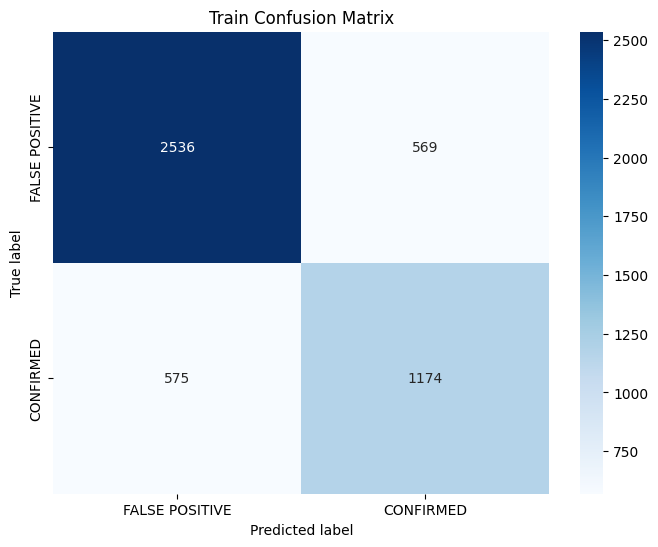

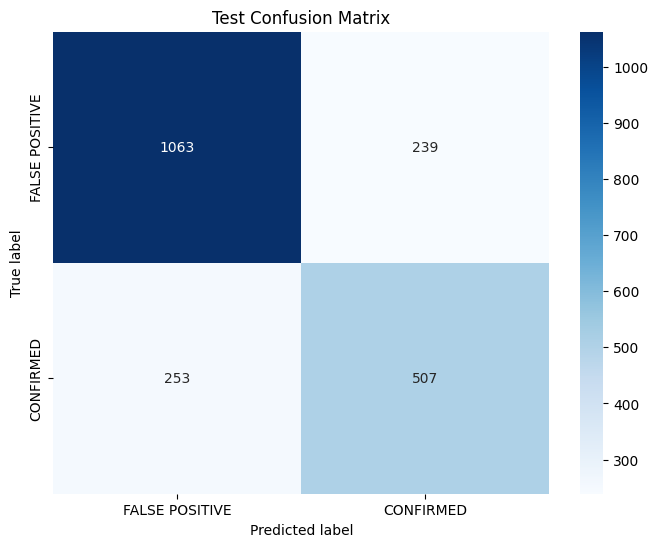

In [22]:

predicted, labels = predict(model, train_loader)
plot_confusion_matrix(labels, predicted, classes, title='Train Confusion Matrix')

predicted, labels = predict(model, test_loader)
plot_confusion_matrix(labels, predicted, classes, title='Test Confusion Matrix')


## Probar el modelo con los datos de CANDIDATOS

In [17]:
global_odd = []
global_even = []
local_odd = []
local_even = []

for lc in tqdm(candidates, desc='Processing light curves'):
    global_odd.append(lc.pliegue_impar_global._light_curve.flux.value)
    global_even.append(lc.pliegue_par_global._light_curve.flux.value)
    local_odd.append(lc.pliegue_impar_local._light_curve.flux.value)
    local_even.append(lc.pliegue_par_local._light_curve.flux.value)

items = []
for i in tqdm(range(len(global_odd)), desc='Creating items'):
    item = {
        'global_odd': global_odd[i],
        'global_even': global_even[i],
        'local_odd': local_odd[i],
        'local_even': local_even[i],
        'label': 2       
    }
    items.append(item)

candidates_dataset = torch.utils.data.TensorDataset(torch.tensor([item['global_odd'] for item in items]),
                                                    torch.tensor([item['global_even'] for item in items]),
                                                    torch.tensor([item['local_odd'] for item in items]),
                                                    torch.tensor([item['local_even'] for item in items]),
                                                    torch.tensor([item['label'] for item in items]))
print("Tamaño del conjunto de candidatos:", len(candidates_dataset))

candidates_loader = DataLoader(candidates_dataset, batch_size=batch_size, shuffle=False)

Creating items: 100%|██████████| 2046/2046 [00:00<00:00, 2046636.29it/s]


Tamaño del conjunto de candidatos: 2046


In [18]:
predicted_candidates, _ = predict(model, candidates_loader)


In [19]:
# contar los positivos y negativos
n_positive = sum(predicted_candidates)
n_negative = len(predicted_candidates) - n_positive
print("Exoplanetas confirmados:", n_positive)
print("Falso positivo:", n_negative)

Exoplanetas confirmados: 822
Falso positivo: 968
